In [1]:
%config IPCompleter.use_jedi = False

In [7]:
!pip install --no-input xlrd

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 96 kB 6.3 MB/s eta 0:00:011


## Get Dataset

### Download data

In [1]:
import os, shutil
# download
!echo "wget ... (TrainSet URL to be published by challenge organizer)"
!echo "wget ... (TestSet URL to be published by challenge organizer)"
# unzip
if not os.path.exists('./TrainSet'):
    !unzip -q -o TrainSet.zip
else:
    print('TrainSet already unzipped.')
if not os.path.exists('./TestSet'):
    !unzip -q -o TestSet.zip
else:
    print('TestSet already unzipped.')
print('Data ready.')    

wget ... (TrainSet URL to be published by challenge organizer)
wget ... (TestSet URL to be published by challenge organizer)
TrainSet already unzipped.
TestSet already unzipped.
Data ready.


### Pre-process images
Pre-processing includes resizing to (224,224) and image intensity normalization to a percentile-range (with previous percentile-based outlier removal).

In [2]:
import pandas as pd
from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import skimage
import skimage.transform
from skimage import io, exposure

def normalize_image_robust(img, pctl_low=0.1, pctl_high=99.9, clip=True, 
                           mask=None, th_low=-np.Inf, th_high=np.Inf):
    # mask and threshold pixel intensities before extracting a lower/upper bound
    if mask is not None:
        # mask (binary) might come from a lung segmentation algorithm, but is not used in this example
        vec = img[mask]
    else:
        vec = img.ravel()
    if isinstance(th_low, str):
        th_low = np.percentile(img, float(th_low))
    if isinstance(th_high, str):
        th_high = np.percentile(img, float(th_high))
    vec = vec[np.logical_and(vec>th_low, vec<th_high)]
    # contrast stretching to lower/upper intensity bound
    img_low = np.percentile(vec, pctl_low)
    img_high = np.percentile(vec, pctl_high)
    img = img-img_low
    img = img/(img_high-img_low)
    if clip:
        img[img<0.0] = 0.0
        img[img>1.0] = 1.0
    # histogram equalization
    img = exposure.equalize_hist(img)
    return img

# filepath list of images
fl_train = glob('./TrainSet/*.png')
fl_test  = glob('./TestSet/*.png')

to_png = False
to_npy = True
for fl, subpath in zip([fl_train, fl_test],
                       ['TrainSet','TestSet']):
    pn_src = os.path.join('.',subpath)
    pn_dst_img = os.path.join('.',subpath+'_224_img')
    pn_dst_npy = os.path.join('.',subpath+'_224_np')
    if not os.path.exists(pn_dst_img):
        os.makedirs(pn_dst_img)
    if not os.path.exists(pn_dst_npy):
        os.makedirs(pn_dst_npy)
    for idx, filepath in enumerate(tqdm(fl)):
        pn, fn = os.path.split(filepath)
        ff_dst_img = os.path.join(pn_dst_img,fn)
        ff_dst_npy = os.path.join(pn_dst_npy,fn.replace('.png','.npy'))
        if (to_png and not os.path.exists(ff_dst_img)) or \
           (to_npy and not os.path.exists(ff_dst_npy)):
            ff_src = os.path.join(pn_src,fn)
            img = io.imread(ff_src)
            img_norm = normalize_image_robust(img, 1.0, 99.0, th_low='0.1', th_high='99.9')
            img_out = skimage.transform.resize(img_norm, (224,224))
            # train set has 4 90deg-ccw rotated images, test has none - unrotate 4 outliers in train set
            if np.any([s in ff_src for s in ['P_1_60', 'P_1_163', 'P_694', 'P_829']]):
                img_out = img_out.T
            # write to disk, either as png and/or as npy
            if to_png:
                io.imsave(ff_dst_img, (img_out*255.0).astype('uint8'))
            if to_npy:
                np.save(ff_dst_npy, img_out.astype('float32'))

print('Image preprocessing (resize/normalize) done.')  

100%|██████████| 486/486 [00:00<00:00, 217734.64it/s]

Image preprocessing (resize/normalize) done.


In [3]:
from time import time
from datetime import datetime

from matplotlib import pylab as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

df = pd.read_excel('./trainClinData.xls')
pd.set_option('display.max_columns', None)
df.describe(include='all')


,Row_number,ImageFile,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Prognosis,Death
count,1103.000000,1103,1103,1102.000000,1103.000000,1064.000000,943.000000,859.000000,1098.000000,1099.000000,1083.000000,1057.000000,1059.000000,272.000000,903.000000,448.000000,845.000000,817.000000,316.000000,739.000000,833.000000,430.000000,812.000000,776.000000,964.000000,829.000000,961.000000,960.000000,960.000000,966.000000,966.000000,963.000000,966.000000,966.000000,966.000000,824.000000,544.000000,983.000000,1103,1103.000000
unique,NaN,1103,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN
top,NaN,P_648.png,F,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SEVERE,NaN
freq,NaN,1,488,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,568,NaN
mean,568.906618,NaN,NaN,64.601433,0.346328,0.957707,37.551856,2.722934,0.522769,0.505005,7.100424,4.572201,33.483664,602.518382,124.817276,55.792165,362.630462,1.373769,2532.160158,92.634777,72.320528,92.444884,33.402254,7.457316,0.299793,0.138721,0.082206,0.020833,0.035417,0.458592,0.155280,0.045691,0.069358,0.073499,0.066253,0.016990,0.110294,0.804680,NaN,0.174977
std,334.640378,NaN,NaN,15.094092,0.476015,0.201352,0.982271,1.020797,0.499709,0.500203,3.835440,0.708783,60.893678,158.364728,60.265937,110.173355,230.489995,3.683051,6490.253237,6.735357,25.543486,7.369730,6.192819,0.055748,0.458405,0.345864,0.274821,0.142901,0.184927,0.498541,0.362359,0.208922,0.254194,0.261089,0.248852,0.129313,0.313544,0.396649,NaN,0.380120
min,1.000000,NaN,NaN,18.000000,0.000000,0.000000,35.400000,0.000000,0.000000,0.000000,0.200000,0.256250,0.010000,102.000000,22.000000,0.020000,0.020000,0.043750,5.610000,50.000000,23.000000,29.000000,16.900000,7.048000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0.000000
25%,279.500000,NaN,NaN,54.000000,0.000000,1.000000,36.800000,2.000000,0.000000,0.000000,4.660000,4.200000,4.170000,511.500000,95.000000,0.090000,238.000000,1.050000,380.250000,90.000000,58.700000,91.000000,30.000000,7.430000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,0.000000
50%,562.000000,NaN,NaN,65.000000,0.000000,1.000000,37.600000,3.000000,1.000000,1.000000,6.260000,4.610000,12.470000,604.000000,109.000000,0.325000,314.000000,1.110000,691.500000,94.900000,68.800000,94.450000,33.000000,7.460000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,0.000000
75%,906.500000,NaN,NaN,77.000000,1.000000,1.000000,38.200000,4.000000,1.000000,1.000000,8.430000,5.040000,28.500000,700.000000,130.000000,15.450000,421.000000,1.230000,1705.500000,97.000000,79.500000,97.000000,36.025000,7.490000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN,0.000000


In [4]:
df.head()

,Row_number,ImageFile,Hospital,Age,Sex,PositivityAtAdmission,Temp_C,DaysFever,Cough,DifficultyInBreathing,WBC,RBC,CRP,Fibrinogen,Glucose,PCT,LDH,INR,D_dimer,Ox_percentage,PaO2,SaO2,PaCO2,pH,CardiovascularDisease,IschemicHeartDisease,AtrialFibrillation,HeartFailure,Ictus,HighBloodPressure,Diabetes,Dementia,BPCO,Cancer,ChronicKidneyDisease,RespiratoryFailure,Obesity,Position,Prognosis,Death
0,82,P_102.png,A,72.000000,1,1.0,37.3,3.0,1.0,0.0,5.37,4.58,3.96,NaN,98.0,NaN,NaN,0.99,NaN,93.0,63.0,93.0,34.0,7.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,SEVERE,0
1,228,P_131.png,D,35.913889,0,1.0,39.3,3.0,1.0,0.0,5.76,5.24,43.40,651.0,NaN,NaN,387.0,1.12,157.0,94.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0,MILD,0
2,229,P_132.png,D,57.266667,0,1.0,37.0,3.0,0.0,0.0,11.48,5.71,64.00,700.0,NaN,NaN,338.0,1.23,601.0,94.0,75.0,96.9,37.0,7.42,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,MILD,0
3,96,P_117.png,A,39.000000,1,1.0,37.2,2.0,1.0,0.0,10.17,3.45,0.75,NaN,80.0,NaN,NaN,1.14,NaN,95.0,77.0,97.0,41.0,7.38,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,MILD,0
4,112,P_16.png,A,44.000000,0,1.0,38.0,3.0,1.0,0.0,6.64,5.55,5.20,NaN,126.0,NaN,NaN,NaN,NaN,93.0,65.0,94.0,37.0,7.47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,SEVERE,0


## EHR pre-processing with Sklearn ColumnTransformer
Combines separate treatment of continuous random variables and categorical variables.

  * **Continuous variables** get median-imputed and scaled robustly from [1,99] percentiles to [0,1] range.
  * **Categorical variables** get one-hot encoded, missing values are treated as a category on its own.

In [5]:
# make a data split and train / testa linear classifier for baseline, then a pytorch MLP model for comparison

# define preprocessor for data columns
# normalize with numeric random variables 
numeric_features = ["Age", "Temp_C", "DaysFever", "WBC", "RBC", "CRP", "Fibrinogen", "Glucose", "PCT", "LDH", "INR", "D_dimer", "Ox_percentage", "PaO2", "SaO2", "PaCO2", "pH"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", RobustScaler(quantile_range=(1.0, 99.0)))]
)
# deal with categorical random variables - we encode missing values (NaNs) as a category on its own
categorical_features = ["Sex", 'PositivityAtAdmission'] + ['Cough','DifficultyInBreathing','CardiovascularDisease','IschemicHeartDisease','AtrialFibrillation','HeartFailure','Ictus','HighBloodPressure','Diabetes','Dementia','BPCO','Cancer','ChronicKidneyDisease','RespiratoryFailure','Obesity','Position']
categorical_transformer = Pipeline(steps=[("onehot", OneHotEncoder(handle_unknown="ignore"))])
# combine into ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", numeric_transformer, numeric_features),
        ("pass", "passthrough", []), # no columns suitable for passthrough in this dataset
    ]
)

# define preprocessor for label column (LabelEncoder)
le = LabelEncoder()
le.fit(['MILD', 'SEVERE'])

# train/test data via split (incl. dataframe re-indexing)
df_train, df_val = train_test_split(df, test_size=0.15, random_state=1) 
df_train['index_orig'] = df_train.index.tolist()
df_train = df_train.reset_index(drop=True)
df_val['index_orig'] = df_val.index.tolist()
df_val = df_val.reset_index(drop=True)

# fit pre-processor  only (!) to train data
preprocessor.fit(df_train)

# append pre-processed features to dataframes
df_train_proc = df_train.copy().assign(EHR=[x for x in preprocessor.transform(df_train)])
df_val_proc = df_val.copy().assign(EHR=[x for x in preprocessor.transform(df_val)])

# load test dataset and apply fitted preprocessor
df_test = pd.read_excel('./completeTestClinData.xls')
df_test['index_orig'] = df_test.index.tolist()
df_test = df_test.reset_index(drop=True)
df_test_proc = df_test.copy().assign(EHR=[x for x in preprocessor.transform(df_test)])

# fit classifers to train data (we ignore validation data here)
naive = np.argmax([np.sum(df_train.Prognosis=='MILD'), np.sum(df_train.Prognosis=='SEVERE')]) # majority class in training set
lr = LogisticRegression(C=1, max_iter=5000)
gbc = GradientBoostingClassifier(random_state=0)
lr.fit(preprocessor.transform(df_train), le.transform(df_train.Prognosis))
gbc.fit(preprocessor.transform(df_train), le.transform(df_train.Prognosis))

# predict on validation and test data
naive_val_preds = np.array([naive]*df_val.shape[0])
lr_val_preds  = lr.predict(preprocessor.transform(df_val))
gbc_val_preds = gbc.predict(preprocessor.transform(df_val))

naive_test_preds = np.array([naive]*df_test.shape[0])
lr_test_preds  = lr.predict(preprocessor.transform(df_test))
gbc_test_preds = gbc.predict(preprocessor.transform(df_test))

# evaluate/report baseline accuracies on validation and test set
print(f'\nBaseline accuracies for validation set:')
print(f'Validation accuracy naive (majority class vote): {accuracy_score(le.transform(df_val.Prognosis), naive_val_preds)}')
print(f'Validation accuracy for LogisticRegression: {accuracy_score(le.transform(df_val.Prognosis), lr_val_preds)}')
print(f'Validation accuracy for GradBoostedClassifier: {accuracy_score(le.transform(df_val.Prognosis), gbc_val_preds)}')

print(f'\nBaseline accuracies for test set:')
print(f'Test accuracy naive (majority class vote): {accuracy_score(le.transform(df_test.Prognosis), naive_test_preds)}')
print(f'Test accuracy for LogisticRegression: {accuracy_score(le.transform(df_test.Prognosis), lr_test_preds)}')
print(f'Test accuracy for GradBoostedClassifier: {accuracy_score(le.transform(df_test.Prognosis), gbc_test_preds)}')


<ipython-input-5-e18dd0f2d20b>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['index_orig'] = df_train.index.tolist()
<ipython-input-5-e18dd0f2d20b>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['index_orig'] = df_val.index.tolist()



Baseline accuracies for validation set:
Validation accuracy naive (majority class vote): 0.5301204819277109
Validation accuracy for LogisticRegression: 0.7228915662650602
Validation accuracy for GradBoostedClassifier: 0.7469879518072289

Baseline accuracies for test set:
Test accuracy naive (majority class vote): 0.37037037037037035
Test accuracy for LogisticRegression: 0.5452674897119342
Test accuracy for GradBoostedClassifier: 0.7366255144032922


In [8]:
# torch imports
import torch
from torch import nn
from torch.nn import Sequential, Linear, ReLU, Dropout, Softmax
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
# Datasets and DataLoader
import monai
from monai.data import PILReader
from monai.data import Dataset, CSVDataset
from monai.data import DataLoader
# ready-made MONAI transforms
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    Compose,
    Lambdad,
    LoadImaged,
    NormalizeIntensityd,
    RandAdjustContrastd,
    RandAffined,
    RandFlipd,
    Resized,
    RepeatChanneld,
    ScaleIntensityRanged,
    ScaleIntensityRange,
    ToTensord,
    Transform
)
# imports for custom MONAI transforms
from monai.utils.enums import TransformBackends
# imports for custom MONAI dictionary transforms
from typing import Any, Callable, Dict, Hashable, List, Mapping, Optional, Sequence, Tuple, Union
from monai.config import DtypeLike, KeysCollection
from monai.config.type_definitions import NdarrayOrTensor
from monai.transforms import RandomizableTransform
from monai.transforms.transform import MapTransform
from monai.transforms.utils import is_positive
from monai.utils import ensure_tuple, ensure_tuple_rep
# network models
from monai.networks.nets import TorchVisionFCModel

monai.config.print_config()

MONAI version: 0.8.1
Numpy version: 1.22.3
Pytorch version: 1.9.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: 71ff399a3ea07aef667b23653620a290364095b1

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.1
scikit-image version: 0.18.2
Pillow version: 8.2.0
Tensorboard version: 2.5.0
gdown version: 3.13.0
TorchVision version: 0.10.0
tqdm version: 4.62.3
lmdb version: 1.2.1
psutil version: 5.8.0
pandas version: 1.2.4
einops version: 0.3.2
transformers version: 4.11.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [9]:
# At the beginning of this notebook, we pre-processed the images in the 
# ai4covid dataset, due to their large variety of image intensities. 
# Instead of performing this step once, and offline, we can also perform
# such transformations with custom MONAI transforms, on-the-fly, as
# implemented here.

class RobustImageScalerAI4C(Transform):
    """
    Apply robust image intensity normalization from percentile-bounds to range [0...1].
    Normalization happens via contrast stretching to percentile-bounds, 
    followed by histogram equalization. Prior to computing the percentile-bounds, 
    there is an option to mask the intensity values with a dense mask, and/or 
    intensity bounds (either absolute, or again via percentiles).
    Default params tuned to train-set of Ai4covid challenge.

    Args:
        pctl_low: lower percentile-bound. Default: 0.1
        pctl_high: upper percentile-bound. Default: 99.9 
        clip: Clip to [0...1] after normalization, or allow outlier values beyond that
              (False would results in output pixel intensities <=0.0 and >=1.0).
              Default: True
        mask: Image mask (binary, same shape as image) to restrict the image regions from 
              which intensity percentiles are computed. Default: None (entire image is used)
        th_low: Intensity bound to create an ad-hoc mask for image intensities
                Can be an absolute intensity value (float) or a percentile (string 
                in range ['0.0'...'100.0']). Default: -np.Inf
        th_high: Upper intensity bound for ad-hoc mask (analoguos to th_low).
                 Default: np.Inf
    """

    def __init__(self, pctl_low=0.1, pctl_high=99.9, clip=True, 
                       mask=None, th_low=-np.Inf, th_high=np.Inf) -> None:
        self.pctl_low = pctl_low
        self.pctl_high = pctl_high
        self.clip = clip
        self.mask = mask
        self.th_low=th_low
        self.th_high=th_high
        if isinstance(self.th_low, str):
            self.th_low = np.percentile(img, float(self.th_low))
        if isinstance(th_high, str):
            self.th_high = np.percentile(img, float(self.th_high))

    def __call__(self, img: np.ndarray) -> np.ndarray:
        """
        normalize Xray images robustly
        """
        ret = self.normalize_image_robust(img)
        return ret
    
    def normalize_image_robust(self, img, mask=None):
        # mask and threshold pixel intensities before extracting a lower/upper bound
        if mask is not None:
            assert mask.shape==img.shape
            # mask (binary) might come from a lung segmentation algorithm, but is not used in this example
            vec = img[self.mask]
        else:
            vec = img.ravel()
        
        vec = vec[np.logical_and(vec>self.th_low, vec<self.th_high)]
        # contrast stretching to lower/upper intensity bound
        img_low = np.percentile(vec, self.pctl_low)
        img_high = np.percentile(vec, self.pctl_high)
        img = img-img_low
        img = img/(img_high-img_low)
        if self.clip:
            img[img<0.0] = 0.0
            img[img>1.0] = 1.0
        # histogram equalization
        img = exposure.equalize_hist(img)
        return img

class RobustImageScalerAI4Cd(MapTransform):
    """
    Dictionary-based wrapper of :py:class:`monai.transforms.SklearnImputer`.
    """

    def __init__(self, keys: KeysCollection, allow_missing_keys: bool = False,
                 pctl_low=0.1, pctl_high=99.9, clip=True, 
                 mask=None, th_low=-np.Inf, th_high=np.Inf,
                 ) -> None:
        """
        Args:
            fitted_transformer: a transformer for tabular data that has already been fit 
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            offset: offset value to shift the intensity of image.
            allow_missing_keys: don't raise exception if key is missing.
        """
        super().__init__(keys, allow_missing_keys)
        self.scaler = RobustImageScalerAI4C(pctl_low=pctl_low, pctl_high=pctl_high, clip=clip, 
                                            mask=mask, th_low=th_low, th_high=th_high)

    def __call__(self, data: Mapping[Hashable, np.ndarray]) -> Dict[Hashable, np.ndarray]:
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.scaler(d[key])
        return d

class RandInvertImaged(RandomizableTransform, MapTransform):
    """
    Dictionary transform: Inverts normalized image intensities from [0...1] to [1...0].
    """

    #backend = RandScaleIntensity.backend

    def __init__(
        self,
        keys: KeysCollection,
        prob: float = 0.1,
        seed: int = None,
        allow_missing_keys: bool = False,
    ) -> None:
        """
        Args:
            keys: keys of the corresponding items to be transformed.
                See also: :py:class:`monai.transforms.compose.MapTransform`
            factors: factor range to randomly scale by ``v = v * (1 + factor)``.
                if single number, factor value is picked from (-factors, factors).
            prob: probability of rotating.
                (Default 0.1, with 10% probability it returns a rotated array.)
            dtype: output data type, if None, same as input image. defaults to float32.
            allow_missing_keys: don't raise exception if key is missing.

        """
        MapTransform.__init__(self, keys, allow_missing_keys)
        RandomizableTransform.__init__(self, prob)
        if seed is not None:
            self.set_random_state(seed)
        self.inverter = ScaleIntensityRange(0.0, 1.0, b_min=1.0, b_max=0.0)
    
    def set_random_state(
        self, seed: Optional[int] = None, state: Optional[np.random.RandomState] = None
    ) -> "RandScaleIntensityd":
        super().set_random_state(seed, state)
        return self
    
    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> Dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        # decide whether to randomly invert or not
        self.randomize(None)
        if not self._do_transform:
            return d
        # invert 
        for key in self.key_iterator(d):
            d[key] = self.inverter(d[key])
        return d

transforms_train = Compose([
        Lambdad(keys="ImageFile", func=lambda filepath: os.path.join(os.getcwd(),
                                                                 'TrainSet_224_np',
                                                                 filepath.replace('.png','.npy'))), # append base path to relative image path
        LoadImaged(keys="ImageFile", image_only=True), 
        AddChanneld(keys="ImageFile"),
        #AsChannelFirstd(keys="ImageFile"),
        #RobustImageScalerAI4Cd(keys="ImageFile"),
        #Resized(keys="ImageFile", spatial_size=(224,224)),
        RandFlipd(keys="ImageFile", prob=0.5, spatial_axis=1),
        RandInvertImaged(keys="ImageFile",prob=0.5,seed=0),
        RandAdjustContrastd(keys="ImageFile", prob=0.5, gamma=(0.5, 2.0)),
        RandAffined(keys="ImageFile", 
                    prob=0.5, 
                    rotate_range=np.pi*30.0/180.0,
                    shear_range=[0.15,0.15], 
                    translate_range=[[-0.1*224, 0.1*224]]*2, 
                    scale_range=0.2,
                    spatial_size=[224,224],
                    padding_mode="zeros",
                    cache_grid=True, 
                    as_tensor_output=True, 
                    device=None),
        RepeatChanneld(keys="ImageFile",repeats=3),
        NormalizeIntensityd(keys="ImageFile", subtrahend=np.array([0.485, 0.456, 0.406]), divisor=np.array([0.229, 0.224, 0.225]), channel_wise=True),
        #ToTensord(keys="ImageFile"),
        ]
)

# significantly faster version if only EHR is used (leave away image I/O transforms)
transforms_train_ehr_only = Compose([
        Lambdad(keys="ImageFile", func=lambda filepath: os.path.join(os.getcwd(),
                                                                 'TrainSet_224_np',
                                                                 filepath.replace('.png','.npy'))), # append base path to relative image path
        ]
)

transforms_val = Compose([
        Lambdad(keys="ImageFile", func=lambda filepath: os.path.join(os.getcwd(),
                                                                 'TrainSet_224_np',
                                                                 filepath.replace('.png','.npy'))), # append base path to relative image path
        LoadImaged(keys="ImageFile", image_only=True), 
        AddChanneld(keys="ImageFile"),
        RepeatChanneld(keys="ImageFile",repeats=3),
        NormalizeIntensityd(keys="ImageFile", subtrahend=np.array([0.485, 0.456, 0.406]), divisor=np.array([0.229, 0.224, 0.225]), channel_wise=True),
        ToTensord(keys="ImageFile"),
        ]
)

transforms_test = Compose([
        Lambdad(keys="ImageFile", func=lambda filepath: os.path.join(os.getcwd(),
                                                                 'TestSet_224_np',
                                                                 filepath.replace('.png','.npy'))), # append base path to relative image path
        LoadImaged(keys="ImageFile", image_only=True), # , reader=PILReader(converter=lambda image: image.convert("RGB")
        AddChanneld(keys="ImageFile"),
        RepeatChanneld(keys="ImageFile",repeats=3),
        NormalizeIntensityd(keys="ImageFile", subtrahend=np.array([0.485, 0.456, 0.406]), divisor=np.array([0.229, 0.224, 0.225]), channel_wise=True),
        ToTensord(keys="ImageFile"),
        ]
)

Elapsed time (N=8): 0.033 sec.


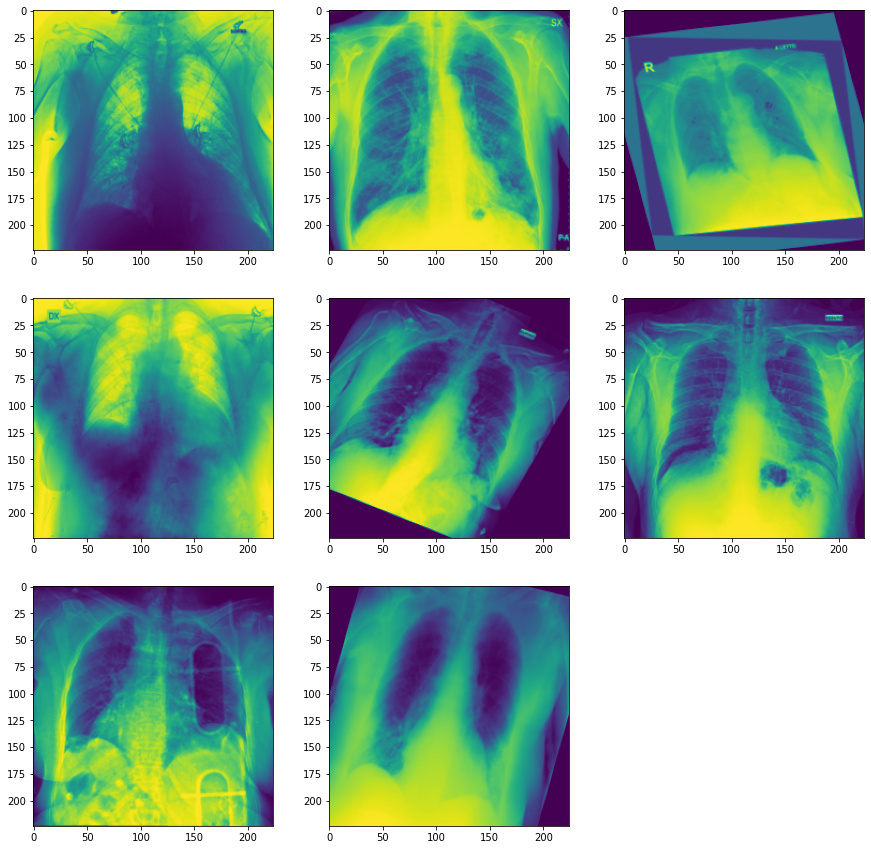

In [10]:
# check our transformation pipeline
data_train = CSVDataset(src=df_train_proc,
                        col_names=['ImageFile', 'EHR', 'Prognosis'], 
                        transform=transforms_train)
batch_size = 8
check_loader = DataLoader(dataset=data_train, batch_size=batch_size, shuffle=True)
t0 = time()
blob = next(iter(check_loader))
print(f'Elapsed time (N={batch_size}): {time()-t0:.3f} sec.')

tiles = int(np.ceil(np.sqrt(batch_size)))
fig = plt.figure(figsize=(tiles*5,tiles*5))
for idx, img in enumerate(blob['ImageFile']):
    fig.add_subplot(tiles,tiles, idx+1)
    plt.imshow(img[0])
plt.show()

In [12]:
class EhrOnlyNet(nn.Module):
    def __init__(self, num_classes=0, input_dim=70, hidden_sizes=[128,128], dropout_rate=0.2):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_sizes = hidden_sizes
        self.input_dim = input_dim
        self.dropout_rate = dropout_rate
        # create MLP
        layers = [Dropout(dropout_rate), Linear(input_dim, hidden_sizes[0]), ReLU()]
        for i in range(1,len(hidden_sizes)):
            layers += [Dropout(dropout_rate), Linear(hidden_sizes[i-1], hidden_sizes[i]), ReLU()]
        # add classification head if needed
        if num_classes>0:
            layers += [Dropout(dropout_rate), Linear(hidden_sizes[-1], num_classes), Softmax(dim=1)]
        self.mlp = Sequential(*layers)
        
    def forward(self, ehr):
        '''Forward pass'''
        return self.mlp(ehr)

class ImageOnlyNet(nn.Module):
    def __init__(self, num_classes=0, hidden_size=512, torchvision_model_id="resnet50", 
                 freeze_backbone=True, freeze_gradcam=False, dropout_rate=0.2):
        super().__init__()
        self.num_classes = num_classes
        self.hidden_size = hidden_size
        self.torchvision_model_id = torchvision_model_id
        self.freeze_backbone = freeze_backbone
        self.freeze_gradcam = freeze_gradcam
        # the CNN implicitly contains a fc layer which embeds into num_classes dimensions
        self.cnn = TorchVisionFCModel(self.torchvision_model_id, 
                                      num_classes=self.hidden_size, 
                                      use_conv=True, 
                                      pretrained=True)
        # Avoid catastrophic forgetting --> freeze all CNN layers except last fc layer
        if self.freeze_backbone:
            if self.freeze_gradcam:
                # # Freeze backbone
                for name, param in self.model.named_parameters():
                    if "features.7" not in name:
                        param.requires_grad = False
                        for param in self.cnn.fc.parameters():
                            param.requires_grad = True
            else:
                for param in self.cnn.parameters():
                    param.requires_grad = False 
                for param in self.cnn.fc.parameters():
                    param.requires_grad = True
        layers = [Dropout(dropout_rate), Linear(hidden_size,hidden_size), ReLU(),
                  Dropout(dropout_rate), Linear(hidden_size,hidden_size), ReLU()]
        self.mlp = Sequential(*layers)
        # add another classification layer fc2
        if self.num_classes>0:
            self.fc1 = nn.Linear(hidden_size,self.num_classes)
            self.softmax = Softmax(dim=1)
        
    def forward(self, images):
        '''Forward pass'''
        x = F.relu(self.cnn(images))
        x = self.mlp(x.squeeze())
        if self.num_classes>0:
            x = self.softmax(self.fc1(x.squeeze()))
        return x

    
    
class MultimodalNet(nn.Module):
    def __init__(self, num_classes=0,
                 kwargs_cnn={},
                 kwargs_ehr={},
                 hidden_sizes=[128,128],
                 dropout_rate=0.2):
        super().__init__()
        # Vision model
        self.cnn = ImageOnlyNet(**kwargs_cnn)
        # EHR model
        self.ehr = EhrOnlyNet(**kwargs_ehr)
        # multimodal MLP model
        layers = [Dropout(dropout_rate), 
                  Linear(self.cnn.hidden_size+self.ehr.hidden_sizes[-1],hidden_sizes[0]), 
                  ReLU()]
        for i in range(1,len(hidden_sizes)):
            layers += [Dropout(dropout_rate), Linear(hidden_sizes[i-1], hidden_sizes[i]), ReLU()]
        if num_classes>0:
            layers += [Dropout(dropout_rate), Linear(hidden_sizes[-1], num_classes), Softmax(dim=1)]
        self.mlp = Sequential(*layers)
        
    def forward(self, images, ehr):
        # single-modal forward passes
        x1 = self.cnn(images)
        x2 = self.ehr(ehr)
        # MLP on multimodal embeddings
        x = torch.cat((x1.squeeze(), x2), dim=1)
        x = self.mlp(x)
        return x
    

device='cuda:0'
# ehr    
model_ehr = EhrOnlyNet(input_dim=70,num_classes=2).to(device)
t0 = time()
test_ehr = model_ehr(blob['EHR'].type(torch.float32).to(device))
print(f'Time elapsed EHR: {time()-t0:.5f}')
# img
model_img = ImageOnlyNet(num_classes=2,
                        torchvision_model_id="resnet18",
                        freeze_gradcam=False).to(device)
t0 = time()
test_img = model_img(blob['ImageFile'].to(device))
print(f'Time elapsed Image: {time()-t0:.5f}')
# mm
model_mm = MultimodalNet(num_classes=2,
                         kwargs_cnn={'hidden_size': 512,
                                    'torchvision_model_id': "resnet18"},
                         kwargs_ehr={'input_dim': 70},
                         hidden_sizes=[128,128]).to(device)
t0 = time()
test_mm = model_mm(blob['ImageFile'].to(device), blob['EHR'].type(torch.float32).to(device))
print(f'Time elapsed Multimodal: {time()-t0:.5f}')

Time elapsed EHR: 0.00100
Time elapsed Image: 0.00650
Time elapsed Multimodal: 0.00667


## Typical torch training and validation loop

In [13]:
def train(train_loader, model, criterion, optimizer, device, data_keys, label_key,
          label_encoder=None, summary_writer=None, summary_writer_offset=0):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    all_predictions = []
    all_targets = []
    for idx, batch_data in enumerate(train_loader):
        
        optimizer.zero_grad()
        
        data = [batch_data[key].type(torch.float32).to(device) for key in data_keys]
        targets = batch_data[label_key]
        if label_encoder is not None:
            targets = label_encoder.transform(targets)
        targets = torch.from_numpy(targets).to(device)
        
        # Forward pass
        predictions = model(*data) 
        loss = criterion(predictions, targets) 
        
        all_predictions.append(predictions)
        all_targets.append(targets)
        
        if summary_writer is not None:
            summary_writer.add_scalar("Loss/train", loss, global_step=summary_writer_offset+idx)
        
        running_loss += loss.item() * data[0].size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss, all_predictions, all_targets

def validate(valid_loader, model, criterion, device, data_keys, label_key,
             label_encoder=None, summary_writer=None, summary_writer_offset=0):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batch_data in valid_loader:
            data = [batch_data[key].type(torch.float32).to(device) for key in data_keys]
            targets = batch_data[label_key]
            if label_encoder is not None:
                targets = label_encoder.transform(targets)
            targets = torch.from_numpy(targets).to(device)

            # Forward pass
            predictions = model(*data) 
            loss = criterion(predictions, targets) 

            running_loss += loss.item() * data[0].size(0)
            all_predictions.append(predictions)
            all_targets.append(targets)
        epoch_loss = running_loss / len(valid_loader.dataset)
        if summary_writer is not None:
            summary_writer.add_scalar("Loss/valid", epoch_loss, global_step=summary_writer_offset)
    
    return model, epoch_loss, all_predictions, all_targets

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, label_key,
                  data_keys=None, label_encoder=None, summary_writer=None, 
                  text_embedder=None, print_every=1):
    '''
    Function defining the entire training loop
    '''
    if data_keys is None:
        print('Training loop requires list of target data keys in batch dictionary.')
        return None, None, None
    
    # set objects for storing metrics
    train_losses = []
    valid_losses = []
    best_valid_loss = 1e10
    best_predictions = None
    best_model = None
    best_epoch = 0
    # Train model
    for epoch in tqdm(range(0, epochs)):

        # training
        #print(f'Epoch {epoch:3d} - Training:')
        model, optimizer, train_loss, all_predictions, all_targets = train(train_loader, model, criterion, optimizer, device, 
                                             data_keys=data_keys, label_key=label_key,
                                             label_encoder=label_encoder, 
                                             summary_writer=summary_writer,
                                             summary_writer_offset=len(train_loader)*epoch)
    
        train_losses.append(train_loss)

        # validation
        if epoch % print_every == (print_every - 1):
            with torch.no_grad():
                #print('Validating:')
                model, valid_loss, all_predictions, all_targets = validate(valid_loader, model, criterion, device,
                                             data_keys=data_keys, label_key=label_key,
                                             label_encoder=label_encoder, 
                                             summary_writer=summary_writer,
                                             summary_writer_offset=len(train_loader)*epoch)
                valid_losses.append(valid_loss)
                if valid_loss<best_valid_loss:
                    best_valid_loss = valid_loss
                    best_model = model
                    best_epoch = epoch
                    best_predictions = all_predictions
                #print(f'{datetime.now().time().replace(microsecond=0)} --- '
                #      f'Epoch: {epoch}\t'
                #      f'Valid loss: {valid_loss:.4f}\t')
    
    return best_model, optimizer, (train_losses, valid_losses), best_predictions, best_epoch

DEVICE = 'cuda:0'
RANDOM_SEED = 0
LEARNING_RATE = 0.00001
BATCH_SIZE = 64
N_EPOCHS = 2000
N_CLASSES = 2

monai.utils.set_determinism(seed=0, additional_settings=None)
torch.manual_seed(RANDOM_SEED)

outputs = {}
for model_tag in ['ehr', 'image', 'multimodal']:
    if model_tag=='image':
        model_data_keys = ['ImageFile']
        model = ImageOnlyNet(num_classes=N_CLASSES, 
                             torchvision_model_id="resnet50", 
                             freeze_backbone=True).to(DEVICE)
        transforms = transforms_train
    elif model_tag=='ehr':
        model_data_keys = ['EHR']
        model = EhrOnlyNet(num_classes=N_CLASSES).to(DEVICE)
        transforms = transforms_train_ehr_only
    else: # model_tag=='multimodal':
        model_data_keys = ['ImageFile', 'EHR']
        model = MultimodalNet(num_classes=N_CLASSES,
                              kwargs_cnn={'freeze_backbone': True,
                                         'torchvision_model_id': "resnet50"}).to(DEVICE)
        transforms = transforms_train

    data_train = CSVDataset(src=df_train_proc,
                            col_names=['ImageFile', 'EHR', 'Prognosis'], 
                            transform=transforms )
    loader_train = DataLoader(dataset=data_train, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=0,
                              #prefetch_factor=16
                             )

    data_valid = CSVDataset(src=df_val_proc,
                            col_names=['ImageFile', 'EHR', 'Prognosis'], 
                            transform=transforms_val)
    loader_valid = DataLoader(dataset=data_valid, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=0)

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    criterion = nn.CrossEntropyLoss()
    
    label_key = 'Prognosis'
    writer = SummaryWriter(f'runs/model_{model_tag}')
    best_model, optimizer, losses, best_predictions, best_epoch = training_loop(model, criterion, optimizer, loader_train, loader_valid, 
                                        N_EPOCHS, DEVICE, label_key,
                                        data_keys=model_data_keys, label_encoder=le, 
                                        summary_writer=writer)
    outputs[model_tag] = {
        'model': best_model,
        'losses': losses,
        'predictions': best_predictions,
        'epoch': best_epoch
    }
    writer.flush()
    writer.close()

# print some results
tgts = le.transform(df_val.Prognosis)
print(f'Validation accuracy naive (majority class vote): {accuracy_score(tgts, naive_val_preds):.5f}')
for model_tag in ['ehr', 'image', 'multimodal']:
    preds = []
    for v in outputs[model_tag]['predictions']:
        preds += list(v.argmax(axis=1).detach().cpu().numpy())
    print(f'Validation accuracy for {model_tag}: {accuracy_score(tgts, preds):.5f}')

# start tensorboard via 
# tensorboard --logdir=./runs --bind_all

100%|██████████| 2000/2000 [1:54:58<00:00,  3.45s/it]


ValueError: Found input variables with inconsistent numbers of samples: [166, 486]

## Run inference on test set

In [14]:
def infer(loader, model, device, data_keys, label_key, label_encoder=None):
    '''
    Function for evaluation on the test set
    '''
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batch_data in loader:
            data = [batch_data[key].type(torch.float32).to(device) for key in data_keys]
            targets = batch_data[label_key]
            if label_encoder is not None:
                targets = label_encoder.transform(targets)
            targets = torch.from_numpy(targets).to(device)
            # Forward pass
            predictions = model(*data) 
            all_predictions.append(predictions)
            all_targets.append(targets)
    return model, all_predictions, all_targets

for model_tag in ['ehr', 'image', 'multimodal']:
    model = outputs[model_tag]['model']
    if model_tag=='image':
        model_data_keys = ['ImageFile']
        transforms = transforms_test
    elif model_tag=='ehr':
        model_data_keys = ['EHR']
        transforms = transforms_train_ehr_only
    else: # model_tag=='multimodal':
        model_data_keys = ['ImageFile', 'EHR']
        transforms = transforms_test
    
    data_test = CSVDataset(src=df_test_proc,
                           col_names=['ImageFile', 'EHR', 'Prognosis'], 
                           transform=transforms_test)
    loader_test = DataLoader(dataset=data_test, 
                              batch_size=BATCH_SIZE, 
                              shuffle=False, 
                              num_workers=0)
    label_key = 'Prognosis'
    model, all_predictions, all_targets = infer(loader_test, model, device,
                                             data_keys=model_data_keys, label_key=label_key,
                                             label_encoder=le)
    outputs[model_tag]['predictions_test'] = all_predictions
    

## Report results on test set

In [15]:
from sklearn.metrics import roc_auc_score, classification_report

for tmp_df, tag, pred_key in zip([df_val, df_test],
                       ['Validation', 'Test'],
                       ['predictions','predictions_test']):
    print('\n********************')
    print(f'Results {tag} set')
    print('********************')
    print('\n*** Prediction accuracy from different models:')
    tgts = le.transform(tmp_df.Prognosis)
    naive_preds = np.array([naive]*tmp_df.shape[0])
    print(f'{tag} accuracy naive (majority class vote): {accuracy_score(tgts, naive_preds):.5f}')
    for model_tag in ['ehr', 'image', 'multimodal']:
        preds = []
        for v in outputs[model_tag][pred_key]:
            preds += list(v.argmax(axis=1).detach().cpu().numpy())
        print(f'{tag} accuracy for {model_tag} (epoch: {outputs[model_tag]["epoch"]}): {accuracy_score(tgts, preds):.5f}')

    # Print accuracy/auc/sensitivity/specificity of the multimodal model
    print('\n*** Further prediction statistics for multimodal model:')
    preds = []
    for v in outputs[model_tag][pred_key]:
        preds += list(v.argmax(axis=1).detach().cpu().numpy())
    preds = np.array(preds)
    preds_proba = []
    for v in outputs[model_tag][pred_key]:
        preds_proba += list(v[:,1].squeeze().detach().cpu().numpy())

    print(f'Accuracy: {accuracy_score(tgts, preds):.3f}')
    print(f'ROC AUC: {roc_auc_score(tgts, preds_proba):.3f}')
    # Note that in binary classification, recall of the positive class is also known as “sensitivity”; recall of the negative class is “specificity”.
    print(classification_report(tgts, preds, target_names=le.classes_))


********************
Results Validation set
********************

*** Prediction accuracy from different models:
Validation accuracy naive (majority class vote): 0.53012
Validation accuracy for ehr (epoch: 1958): 0.74699
Validation accuracy for image (epoch: 1546): 0.68072
Validation accuracy for multimodal (epoch: 1899): 0.75904

*** Further prediction statistics for multimodal model:
Accuracy: 0.759
ROC AUC: 0.770
              precision    recall  f1-score   support

        MILD       0.74      0.74      0.74        78
      SEVERE       0.77      0.77      0.77        88

    accuracy                           0.76       166
   macro avg       0.76      0.76      0.76       166
weighted avg       0.76      0.76      0.76       166


********************
Results Test set
********************

*** Prediction accuracy from different models:
Test accuracy naive (majority class vote): 0.37037
Test accuracy for ehr (epoch: 1958): 0.74074
Test accuracy for image (epoch: 1546): 0.56379
T

In [16]:
# save the three models
# Specify a path
pn = './results_v2_withTorchVisionImageNormalization'
if not os.path.exists(pn):
    os.makedirs(pn)
for model_tag in ['ehr', 'image', 'multimodal']:
    fn = model_tag+'.pt'
    ff = os.path.join(pn,fn)
    # Save
    torch.save(outputs[model_tag]['model'].state_dict(), ff)

# Load
#model = Net()
#model.load_state_dict(torch.load(PATH))
#model.eval()